# Thresholds for "similar" in fingerprints the RDKit supports

What fraction of the database do we retrieve?

<table>

</table>


In [1]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
from rdkit import DataStructs
from collections import defaultdict
import pickle,random,gzip
import pandas as pd
import numpy as np
print(rdBase.rdkitVersion)
import time
print(time.asctime())
%pylab inline


2021.03.1
Thu May 20 18:37:48 2021
Populating the interactive namespace from numpy and matplotlib


/home/glandrum/miniconda3/envs/rdkit_blog/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Read in the reference data

100K randomly chosen compounds from ChEMBL28


In [7]:
import psycopg2
cn = psycopg2.connect(host='localhost',dbname='chembl_28')
curs = cn.cursor()
curs.execute('''select chembl_id,mol_send(m) from rdk.mols tablesample BERNOULLI(5) 
  join chembl_id_lookup on (molregno=entity_id and entity_type='COMPOUND')
  limit 100000''')
chembl_data = curs.fetchall()
chembl_data = [(x,y.tobytes()) for x,y in chembl_data]

# Read in the query data

In [11]:
# we will use a namedtuple to return the results
from collections import namedtuple
MCSRes=namedtuple('MCSRes',('smarts','numAtoms','numMols','avgNumMolAtoms','mcsTime'))

data = pickle.load(open('../data/scaffolds_revisited_again.pkl','rb'))
keep = [x for x in data if x[2].numAtoms>=np.mean(x[2].avgNumMolAtoms)/2]
all_queries = []
for assay,smis,mcs,_ in keep:
    all_queries.extend(smis)

Limit it to 1K queries

In [13]:
import random
random.seed(0xf00d)
random.shuffle(all_queries)

all_queries = all_queries[:1000]
all_queries = [Chem.MolFromSmiles(x[1]) for x in all_queries]

# Similarities

In [46]:
try:
    import ipyparallel as ipp
    rc = ipp.Client()
    dview = rc[:]
    dview.execute('from rdkit import Chem')
    dview.execute('from rdkit import Descriptors')
    dview.execute('from rdkit import DataStructs')
    dview.execute('from rdkit.Chem import rdMolDescriptors')
    dview.execute('from rdkit.Avalon import pyAvalonTools')
except:
    print("could not use ipyparallel")
    dview = None

def smi_to_fp(row,fpfn):
    mol = Chem.MolFromSmiles(row[1])
    return fpfn(mol)

def calc_sims(fp,db):
    return DataStructs.BulkTanimotoSimilarity(fp,db)

from collections import defaultdict
import bisect
def compareFPs(queries,db,fpfn,fpName,accum):
    if dview is not None:
        qfps = dview.map_sync(lambda x:fpfn(x),queries)
        dbfps = dview.map_sync(lambda x:fpfn(Chem.Mol(x[1])),db)
    else:
        qfps = [fpfn(x) for x in queries]
        dbfps = [fpfn(Chem.Mol(x[1])) for x in db]
                               
    dbsize=len(db)
    accums = defaultdict(list)
    for x in qfps:
        tmp = sorted(calc_sims(x,dbfps))
        for bin in (.2,.3,.4,.5,.6,.7,.8,.9,.95):
            accums[bin].append(dbsize - bisect.bisect(tmp,bin))
           
    qfps = None
    dbfps = None
                               
    for bin in (.2,.3,.4,.5,.6,.7,.8,.9,.95):
        cnts = accums[bin]        
        accum[fpName][bin] = np.median(cnts)/dbsize
   

In [50]:
accum = defaultdict(dict)

# MACCS

In [51]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetMACCSKeysFingerprint(x),"MACCS",accum)
    

# Morgan FPs

## count based

In [53]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetMorganFingerprint(x,0),"Morgan0 (counts)",accum)    

In [54]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetMorganFingerprint(x,1),"Morgan1 (counts)",accum)    

In [55]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetMorganFingerprint(x,2),"Morgan2 (counts)",accum)    

In [56]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetMorganFingerprint(x,3),"Morgan3 (counts)",accum)    

## bit-vector based

In [57]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetHashedMorganFingerprint(x,0,1024),"Morgan0 (bits)",accum)    

In [58]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetHashedMorganFingerprint(x,1,1024),"Morgan1 (bits)",accum)    

In [59]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetHashedMorganFingerprint(x,2,1024),"Morgan2 (bits)",accum)    

In [60]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetHashedMorganFingerprint(x,3,1024),"Morgan3 (bits)",accum)    

# FeatMorgan

## count based

In [61]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetMorganFingerprint(x,0,useFeatures=True),"FeatMorgan0 (counts)",accum)    

In [62]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetMorganFingerprint(x,1,useFeatures=True),"FeatMorgan1 (counts)",accum)    

In [63]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetMorganFingerprint(x,2,useFeatures=True),"FeatMorgan2 (counts)",accum)    

In [64]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetMorganFingerprint(x,3,useFeatures=True),"FeatMorgan3 (counts)",accum)    

## bit vectors

In [65]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetHashedMorganFingerprint(x,0,1024,useFeatures=True),"FeatMorgan0 (bits)",accum)    

In [66]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetHashedMorganFingerprint(x,1,1024,useFeatures=True),"FeatMorgan1 (bits)",accum)    

In [67]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetHashedMorganFingerprint(x,2,1024,useFeatures=True),"FeatMorgan2 (bits)",accum)    

In [68]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetHashedMorganFingerprint(x,3,1024,useFeatures=True),"FeatMorgan3 (bits)",accum)    

# RDKit

## Branched (default)

In [69]:
compareFPs(all_queries,chembl_data,lambda x:Chem.RDKFingerprint(x,maxPath=4),"RDKit 4 (bits)",accum)

In [70]:
compareFPs(all_queries,chembl_data,lambda x:Chem.RDKFingerprint(x,maxPath=5),"RDKit 5 (bits)",accum)

In [71]:
compareFPs(all_queries,chembl_data,lambda x:Chem.RDKFingerprint(x,maxPath=6),"RDKit 6 (bits)",accum)

In [72]:
compareFPs(all_queries,chembl_data,lambda x:Chem.RDKFingerprint(x,maxPath=7),"RDKit 7 (bits)",accum)

## linear

In [73]:
compareFPs(all_queries,chembl_data,lambda x:Chem.RDKFingerprint(x,maxPath=4,branchedPaths=False),"linear RDKit 4 (bits)",accum)

In [74]:
compareFPs(all_queries,chembl_data,lambda x:Chem.RDKFingerprint(x,maxPath=5,branchedPaths=False),"linear RDKit 5 (bits)",accum)

In [75]:
compareFPs(all_queries,chembl_data,lambda x:Chem.RDKFingerprint(x,maxPath=6,branchedPaths=False),"linear RDKit 6 (bits)",accum)

In [76]:
compareFPs(all_queries,chembl_data,lambda x:Chem.RDKFingerprint(x,maxPath=7,branchedPaths=False),"linear RDKit 7 (bits)",accum)

# Atom pairs and torsions

## count-based

In [77]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetAtomPairFingerprint(x),
                                 "Atom Pairs (counts)",accum)

In [78]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetTopologicalTorsionFingerprint(x),
                                 "Topological Torsions (counts)",accum)

## bit vectors

In [79]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(x),
                                 "Atom Pairs (bits)",accum)

In [80]:
compareFPs(all_queries,chembl_data,lambda x:rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(x),
                                 "Topological Torsions (bits)",accum)

# Avalon

In [81]:
compareFPs(all_queries,chembl_data,lambda x:pyAvalonTools.GetAvalonFP(x,512),"Avalon 512 (bits)",accum)

In [82]:
compareFPs(all_queries,chembl_data,lambda x:pyAvalonTools.GetAvalonFP(x,1024),"Avalon 1024 (bits)",accum)

# Avalon Counts

In [83]:
compareFPs(all_queries,chembl_data,lambda x:pyAvalonTools.GetAvalonCountFP(x,512),"Avalon 512 (counts)",accum)

In [84]:
compareFPs(all_queries,chembl_data,lambda x:pyAvalonTools.GetAvalonCountFP(x,1024),"Avalon 1024 (counts)",accum)

In [85]:
pickle.dump(accum,open('./results/fp_thresholds_database_accum.pkl','wb+'))

# Analysis

In [2]:
accum = pickle.load(open('./results/fp_thresholds_database_accum.pkl','rb'))

In [4]:
accum['MACCS']

{0.2: 0.973175,
 0.3: 0.839035,
 0.4: 0.54832,
 0.5: 0.20019,
 0.6: 0.042525,
 0.7: 0.00286,
 0.8: 9e-05,
 0.9: 1e-05,
 0.95: 0.0}

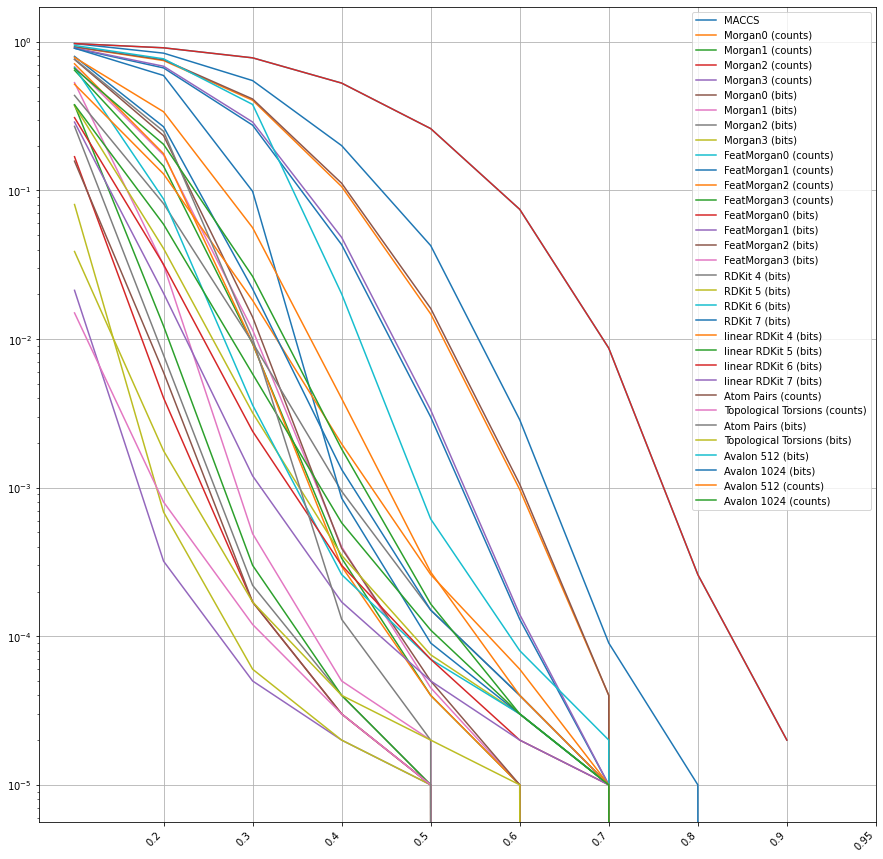

In [10]:
figsize(15,15)
for k in accum:
    bins = accum[k].keys()
    vs = accum[k].values()
    plot(vs,label=k)
    xticks(rotation=45,ha='right');
    xticks(range(1,len(bins)+1),bins);
    #title('0.2');
yscale('log')
grid();
legend();

In [17]:
from ipywidgets import widgets,interact

@interact(accum=widgets.fixed(accum),
          ks=widgets.SelectMultiple(options=accum.keys(),
                                    value=['MACCS'],
                                    description="fingerprints"))
def plotvals(accum,ks):
    figsize(15,15)
    for k in ks:
        bins = accum[k].keys()
        vs = accum[k].values()
        plot(vs,label=k)
        xticks(rotation=45,ha='right');
        xticks(range(1,len(bins)+1),bins);
        #title('0.2');
    #ylim(0,1)
    yscale('log')
    grid();
    legend();

interactive(children=(SelectMultiple(description='fingerprints', index=(0,), options=('MACCS', 'Morgan0 (count…

In [3]:
scaff_accum = pickle.load(open('./results/fp_thresholds_scaffolds_accum.pkl','rb'))

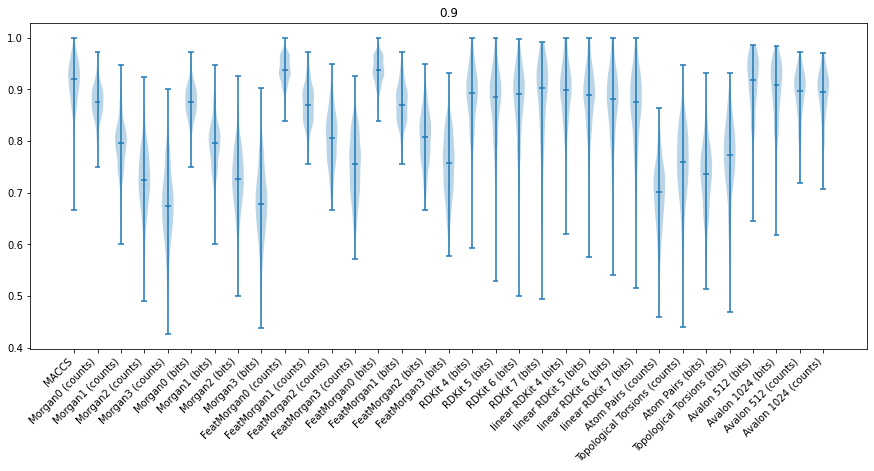

In [4]:
figsize(15,6)
fpnames = list(scaff_accum.values())[0].keys()
d = []
for nm in fpnames:
    d.append([x[nm][0.9] for x in scaff_accum.values()])
violinplot(d,showmedians=True);
xticks(rotation=45,ha='right');
xticks(range(1,len(d)+1),fpnames);
title('0.9');

In [7]:
fp = 'RDKit 7 (bits)'
thresh=0.1

ds = [x[fp][thresh] for x in scaff_accum.values()]
med = np.median(ds)
bin = round(10*med)/10
print(f'{np.quantile(ds,0.2):.2f} {med:.2f} {np.quantile(ds,0.8):.2f}')
print(f'{med} {bin} {accum[fp][bin]} {int(accum[fp][bin]*1e6)}')

0.42 0.58 0.71
0.5770049680624556 0.6 9e-05 90


In [55]:
def interp(where,lookup):
    bins = sorted(lookup.keys())
    if where <= bins[0]:
        return lookup[bins[0]]
    for i,b in enumerate(bins):
        if not i:
            continue
        if where==b:
            return lookup[b]
        elif where<b:
            bl = bins[i-1]
            vl = lookup[bl]
            vu = lookup[b]
            frac = (where-b)/(bl-b)
            return vl+frac*(vu-vl)
    return lookup[bins[-1]]
            

In [56]:
interp(0.5777,accum[fp])

0.00026921500000000006

In [61]:
fp = 'Morgan1 (counts)'

for thresh in (0.1,0.2,0.5):
    ds = [x[fp][thresh] for x in scaff_accum.values()]
    med = np.median(ds)
    bin = round(20*med)/20
    tval = interp(bin,accum[fp])
    #print(f'{np.quantile(ds,0.2):.2f} {med:.2f} {np.quantile(ds,0.8):.2f}')
    print(f'{thresh} {med:.2f} {bin} {tval} {int(tval*1e6)}')

0.1 0.48 0.5 0.000335 335
0.2 0.53 0.55 0.00018750000000000017 187
0.5 0.63 0.65 2.5000000000000018e-05 25


In [71]:
background_accum = pickle.load(open('./results/fp_thresholds_random_accum.pkl','rb'))

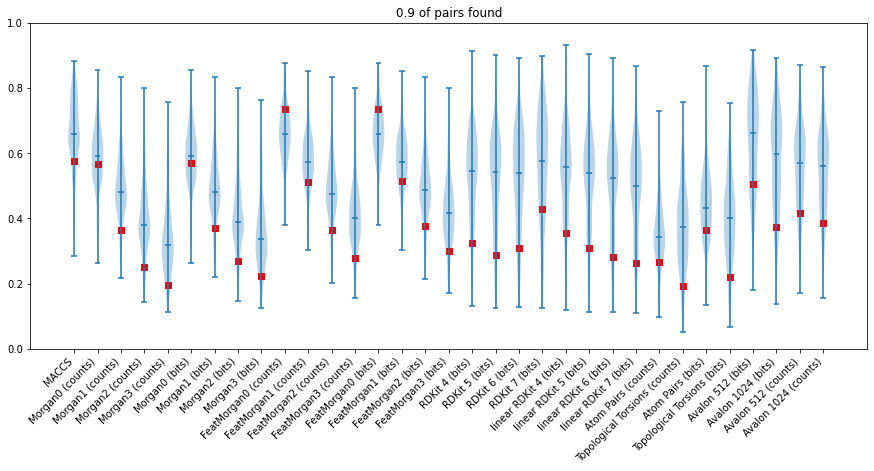

In [98]:
thresh = 0.1

figsize(15,6)
fpnames = list(scaff_accum.values())[0].keys()
d = []
lbounds = []
for nm in fpnames:
    d.append([x[nm][thresh] for x in scaff_accum.values()])
    lbounds.append(background_accum[nm][0.95])
violinplot(d,showmedians=True);
scatter(range(1,len(fpnames)+1),lbounds,c='red',marker='s')
xticks(rotation=45,ha='right');
xticks(range(1,len(d)+1),fpnames);
ylim(0,1);
title(f'{1-thresh} of pairs found');

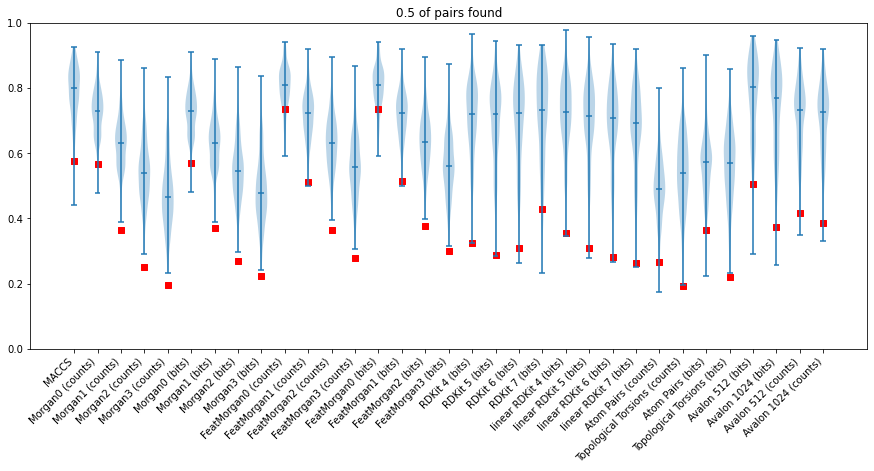

In [99]:
thresh = 0.5

figsize(15,6)
fpnames = list(scaff_accum.values())[0].keys()
d = []
lbounds = []
for nm in fpnames:
    d.append([x[nm][thresh] for x in scaff_accum.values()])
    lbounds.append(background_accum[nm][0.95])
violinplot(d,showmedians=True);
scatter(range(1,len(fpnames)+1),lbounds,c='red',marker='s')
xticks(rotation=45,ha='right');
xticks(range(1,len(d)+1),fpnames);
ylim(0,1);
title(f'{1-thresh} of pairs found');

In [73]:
fps = list(list(scaff_accum.values())[0].keys())
all_thresholds = list(list(scaff_accum.values())[0][fps[0]].keys())
thresholds = [0.05,0.1,0.2,0.5]
for fp in fps:
    print('------------------------')
    for thresh in thresholds:
        ds = [x[fp][thresh] for x in scaff_accum.values()]
        med = np.median(ds)
        bin = round(20*med)/20
        tval = interp(bin,accum[fp])
        print(f'{fp} {background_accum[fp][0.95]:.2f} {1.-thresh} {bin} {tval:.2g} {int(tval*1e6)}')        


------------------------
MACCS 0.57 0.95 0.6 0.043 42525
MACCS 0.57 0.9 0.65 0.023 22692
MACCS 0.57 0.8 0.7 0.0029 2860
MACCS 0.57 0.5 0.8 9e-05 90
------------------------
Morgan0 (counts) 0.57 0.95 0.55 0.06 60417
Morgan0 (counts) 0.57 0.9 0.6 0.015 14750
Morgan0 (counts) 0.57 0.8 0.65 0.0079 7860
Morgan0 (counts) 0.57 0.5 0.75 0.00051 505
------------------------
Morgan1 (counts) 0.36 0.95 0.45 0.0048 4807
Morgan1 (counts) 0.36 0.9 0.5 0.00034 335
Morgan1 (counts) 0.36 0.8 0.55 0.00019 187
Morgan1 (counts) 0.36 0.5 0.65 2.5e-05 25
------------------------
Morgan2 (counts) 0.25 0.95 0.35 0.0021 2092
Morgan2 (counts) 0.25 0.9 0.4 0.00017 170
Morgan2 (counts) 0.25 0.8 0.45 0.0001 100
Morgan2 (counts) 0.25 0.5 0.55 2e-05 20
------------------------
Morgan3 (counts) 0.20 0.95 0.3 0.00032 320
Morgan3 (counts) 0.20 0.9 0.3 0.00032 320
Morgan3 (counts) 0.20 0.8 0.35 0.00018 184
Morgan3 (counts) 0.20 0.5 0.45 3.5e-05 35
------------------------
Morgan0 (bits) 0.57 0.95 0.55 0.064 63897
Morga

Same thing, formatted for the blog post

In [85]:
fps = list(list(scaff_accum.values())[0].keys())
all_thresholds = list(list(scaff_accum.values())[0][fps[0]].keys())
thresholds = [0.05,0.1,0.2,0.5]
headings1 = ["<th></th>"]*2
headings2 = ["<th>Fingerprint</th>","<th>0.95 noise level</th>"]
for thresh in thresholds:
    headings1.append(f'<th colspan="2">{1-thresh} of related compounds</th>')
    headings2.extend(['<th>threshold</th>','<th>db fraction / count per million</th>'])
print("<table>")
print(f"<tr>{' '.join(headings1)}</tr>")
print(f"<tr>{' '.join(headings2)}</tr>")
for fp in fps:
    print('<tr>')
    print(f'<td><b>{fp}</b></td> <td>{background_accum[fp][0.95]:.2f}</td>',end=" ")
    for thresh in thresholds:
        ds = [x[fp][thresh] for x in scaff_accum.values()]
        med = np.median(ds)
        bin = round(20*med)/20
        tval = interp(bin,accum[fp])
        print(f'<td>{bin}</td> <td>{tval:.2g} / {int(tval*1e6)}</td>',end=" ")
    print('</tr>')
print("</table>")


<table>
<tr><th></th> <th></th> <th colspan="2">0.95 of related compounds</th> <th colspan="2">0.9 of related compounds</th> <th colspan="2">0.8 of related compounds</th> <th colspan="2">0.5 of related compounds</th></tr>
<tr><th>Fingerprint</th> <th>0.95 noise level</th> <th>threshold</th> <th>db fraction / count per million</th> <th>threshold</th> <th>db fraction / count per million</th> <th>threshold</th> <th>db fraction / count per million</th> <th>threshold</th> <th>db fraction / count per million</th></tr>
<tr>
<td><b>MACCS</b></td> <td>0.57</td> <td>0.6</td> <td>0.043 / 42525</td> <td>0.65</td> <td>0.023 / 22692</td> <td>0.7</td> <td>0.0029 / 2860</td> <td>0.8</td> <td>9e-05 / 90</td> </tr>
<tr>
<td><b>Morgan0 (counts)</b></td> <td>0.57</td> <td>0.55</td> <td>0.06 / 60417</td> <td>0.6</td> <td>0.015 / 14750</td> <td>0.65</td> <td>0.0079 / 7860</td> <td>0.75</td> <td>0.00051 / 505</td> </tr>
<tr>
<td><b>Morgan1 (counts)</b></td> <td>0.36</td> <td>0.45</td> <td>0.0048 / 4807</td> 

In [87]:
background_accum['Morgan2 (bits)'][0.95]

0.2689655172413793